# Convert a TensorFlow Model to OpenVINO™

This short tutorial shows how to convert a TensorFlow [MobileNetV3](https://docs.openvino.ai/latest/omz_models_model_mobilenet_v3_small_1_0_224_tf.html) image classification model to OpenVINO [Intermediate Representation](https://docs.openvino.ai/latest/openvino_docs_MO_DG_IR_and_opsets.html) (OpenVINO IR) format, using [Model Optimizer](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html). After creating the OpenVINO IR, load the model in [OpenVINO Runtime](https://docs.openvino.ai/latest/openvino_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html) and do inference with a sample image.  

## Imports

In [1]:
import time
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown
import openvino.runtime as ov
from openvino.runtime import Core, Layout, Type

## Settings

In [2]:
# The paths of the source and converted models.
model_path = Path("/home/fiborobotlab/models/classification/chess/MobileNetV2_binary/saved_model.pb")
# model_path = Path("/home/fiborobotlab/models/classification/chess/MobileNetV2_color/saved_model.pb")
ir_path = Path(model_path).with_suffix(".xml")

## Convert a Model to OpenVINO IR Format

### Convert a TensorFlow Model to OpenVINO IR Format

Use Model Optimizer to convert a TensorFlow model to OpenVINO IR with `FP16` precision. The models are saved to the current directory. Add mean values to the model and scale the output with the standard deviation with `--scale_values`. With these options, it is not necessary to normalize input data before propagating it through the network. The original model expects input images in `RGB` format. The converted model also expects images in `RGB` format. If you want the converted model to work with `BGR` images, use the `--reverse-input-channels` option. For more information about Model Optimizer, including a description of the command-line options, see the [Model Optimizer Developer Guide](https://docs.openvino.ai/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html). For information about the model, including input shape, expected color order and mean values, refer to the [model documentation](https://docs.openvino.ai/latest/omz_models_model_mobilenet_v3_small_1_0_224_tf.html).

First construct the command for Model Optimizer, and then execute this command in the notebook by prepending the command with an `!`. There may be some errors or warnings in the output. When model optimization is successful, the last lines of the output will include `[ SUCCESS ] Generated IR version 11 model.`

In [3]:
# Construct the command for Model Optimizer.
mo_command = f"""mo
                 --saved_model_dir "{model_path.parent}"
                 --input_shape "[-1,224,224,3]"
                 --mean_values="[127.5,127.5,127.5]"
                 --scale_values="[127.5]"
                 --data_type FP32
                 --framework="tf"
                 --output_dir "{model_path.parent}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert TensorFlow to OpenVINO:")
display(Markdown(f"`{mo_command}`"))

Model Optimizer command to convert TensorFlow to OpenVINO:


`mo --saved_model_dir "/home/fiborobotlab/models/classification/chess/MobileNetV2_binary" --input_shape "[-1,224,224,3]" --mean_values="[127.5,127.5,127.5]" --scale_values="[127.5]" --data_type FP32 --framework="tf" --output_dir "/home/fiborobotlab/models/classification/chess/MobileNetV2_binary"`

In [4]:
# Run Model Optimizer if the IR model file does not exist
if not ir_path.exists():
    print("Exporting TensorFlow model to IR... This may take a few minutes.")
    ! $mo_command
else:
    print(f"IR model {ir_path} already exists.")

IR model /home/fiborobotlab/models/classification/chess/MobileNetV2_binary/saved_model.xml already exists.


## Test Inference on the Converted Model

### Load an Image

Load an image, resize it, and convert it to the input shape of the network.

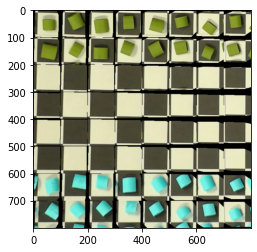

In [5]:
# The MobileNet network expects images in RGB format.
image = cv2.imread(filename="../test_CNNinputs.png")
plt.imshow(image)
CNNinputs_resized = []
for i in range(8):
    for j in range(8):
        tile_img = image[100*i:100*(i+1),100*j:100*(j+1)]
        # Resize the image to the network input shape.
        resized_image = cv2.resize(src=tile_img, dsize=(224, 224))
        # Transpose the image to the network input shape.
        input_image = np.expand_dims(resized_image, 0)
        CNNinputs_resized.append(input_image)

### Load the Model (batched inference)

In [6]:
ie = Core()
print("Avaliable devices:")
print(ie.available_devices)
model = ie.read_model(model=ir_path, weights=ir_path.with_suffix(".bin"))
model.reshape([64, 224, 224, 3])
# compiled_model = ie.compile_model(model=model, device_name="CPU")
compiled_model = ie.compile_model(model, "GPU", {"PERFORMANCE_HINT": "THROUGHPUT"})
# get model information
input_key = compiled_model.input(0)
print(input_key)
output_key = compiled_model.output(0)
print(output_key)
network_input_shape = input_key.shape
print(network_input_shape)

Avaliable devices:
['CPU', 'GNA', 'GPU']
<ConstOutput: names[input_2:0, Func/StatefulPartitionedCall/input/_0:0] shape{64,224,224,3} type: f32>
<ConstOutput: names[StatefulPartitionedCall/model/dense/BiasAdd:0, StatefulPartitionedCall/Identity:0, Identity:0, Func/StatefulPartitionedCall/output/_263:0] shape{64,1} type: f32>
{64, 224, 224, 3}


In [7]:
## Do Inference
infer_request = compiled_model.create_infer_request()
# Set the tensor as an input for the infer request
infer_request.infer([CNNinputs_resized])
output_tensor = infer_request.get_output_tensor()
print(output_tensor.data[:].reshape(8, 8))

# result = compiled_model(CNNinputs_resized)[output_key]
# print(result)

        # result_index = np.argmax(result)
        # plt.imshow(tile_img)
        # print(result_index)

[[  5.8085938    6.1328125    2.7734375   11.828125     6.7070312
   14.0703125   16.359375    10.7578125 ]
 [ -5.5664062   -3.5898438    1.1240234    8.6328125   12.5546875
    9.875       19.34375     20.875     ]
 [-10.1484375   -0.97216797  -9.2734375   -4.1796875  -16.328125
   -1.5175781   -9.3046875   -2.2988281 ]
 [ -2.3417969  -11.625       -1.0537109  -11.5625      -1.2763672
  -12.78125     -3.3125     -11.6484375 ]
 [ -9.9296875   -2.375      -10.03125     -8.0703125  -12.75
   -5.046875   -16.265625    -3.9863281 ]
 [ -8.875       -8.453125    -4.5546875  -10.0546875   -4.8515625
  -15.8671875   -7.3554688  -10.328125  ]
 [ -5.6601562    4.5117188    7.1640625    7.9726562    4.4882812
   15.           8.6015625   17.28125   ]
 [ -2.1660156    2.9570312    6.3046875   -1.8232422    8.5078125
    4.515625    11.609375    16.078125  ]]


### Load the model (dynamic batch inference)

In [8]:
from openvino.preprocess import PrePostProcessor, ResizeAlgorithm
ie = Core()
print("Avaliable devices:")
print(ie.available_devices)
model = ie.read_model(model=ir_path)
# for output_key in model.outputs:
#     for op in model.get_ops():
#         if op.get_type_name() == 'Convolution':
#             output_name, output_info = output_key, model.outputs[output_key.get_index()]
if len(model.inputs) != 1:
    print('Sample supports only single input topologies')
if len(model.outputs) != 1:
    print('Sample supports only single output topologies')

input_tensor = np.array(CNNinputs_resized, dtype=np.uint8).reshape(-1, 224, 224, 3)
ppp = PrePostProcessor(model)
_, h, w, _ = input_tensor.shape
ppp.input().tensor() \
        .set_element_type(Type.u8) \
        .set_layout(Layout('NHWC')) \
        .set_spatial_static_shape(h, w)  # noqa: ECE001, N400
ppp.input().preprocess().resize(ResizeAlgorithm.RESIZE_LINEAR)
# ppp.input().model().set_layout(Layout('NCHW'))
ppp.output().tensor().set_element_type(Type.f16)
model = ppp.build()
compiled_model = ie.compile_model(model, 'CPU')
results = compiled_model.infer_new_request({0: input_tensor})
print(results)

Avaliable devices:
['CPU', 'GNA', 'GPU']
{<ConstOutput: names[StatefulPartitionedCall/model/dense/BiasAdd:0, StatefulPartitionedCall/Identity:0, Identity:0, Func/StatefulPartitionedCall/output/_263:0] shape{?,1} type: f16>: array([[  5.812],
       [  6.105],
       [  3.023],
       [ 11.84 ],
       [  6.79 ],
       [ 14.13 ],
       [ 16.4  ],
       [ 10.79 ],
       [ -5.   ],
       [ -3.562],
       [  1.631],
       [  8.65 ],
       [ 12.65 ],
       [ 10.   ],
       [ 19.64 ],
       [ 20.75 ],
       [-10.13 ],
       [ -1.06 ],
       [ -9.46 ],
       [ -4.266],
       [-16.12 ],
       [ -1.609],
       [ -9.336],
       [ -2.   ],
       [ -2.365],
       [-11.695],
       [ -0.823],
       [-11.38 ],
       [ -1.36 ],
       [-12.59 ],
       [ -3.174],
       [-11.484],
       [ -9.92 ],
       [ -2.387],
       [ -9.86 ],
       [ -8.14 ],
       [-12.55 ],
       [ -5.26 ],
       [-16.14 ],
       [ -3.81 ],
       [ -8.91 ],
       [ -8.57 ],
       [ -4.54 ],
  